In [ ]:
import numpy as np
from scipy.special import logsumexp
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import random
import itertools
import pandas as pd
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Dataloading

In [ ]:
# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Vectorize images
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
# Print data shapes
print("Shape of training set: ", X_train.shape)
print("Shape of testing set: ", X_test.shape)
# Normalize the data
X_train = X_train/255
X_test = X_test/255

# Check for aberrations in datasets (we know Y should be fine because otherwise to_categorical would raise an error)
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
      if not (X_train[i,j] >= 0 and X_train[i,j] <= 1):
          print(i, " ", j, " ", X_train[i,j])
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
      if not (X_test[i,j] >= 0 and X_test[i,j] <= 1):
          print(i, " ", j, " ", X_test[i,j])

Shape of training set:  (60000, 784)
Shape of testing set:  (10000, 784)


In [ ]:
print('Number of instances for each class in the training set: ')
bins = np.bincount(y_train)
print(bins)
print('Mean %.2f (SD: %.2f)' % (np.mean(bins), np.std(bins)))
print('\nNumber of instances for each class in the testing set: ')
print(np.bincount(y_test))
print('Mean %.2f (SD: %.2f)' % (np.mean(bins), np.std(bins)))

Number of instances for each class in the training set: 
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Mean 6000.00 (SD: 322.08)

Number of instances for each class in the testing set: 
[ 980 1135 1032 1010  982  892  958 1028  974 1009]
Mean 6000.00 (SD: 322.08)


In [ ]:
# To speed up debugging
# X_train = X_train[:10000]
# y_train = y_train[:10000]

#Training Functions

In [ ]:
def random_search(hyperparameters, n_samples, RAND=None):
    keys_to_permut = []
    vals_to_permut = []
    for key, val in hyperparameters.items():
        keys_to_permut.append(key)
        vals_to_permut.append(val)

    vals_permut = itertools.product(*vals_to_permut)
    random.seed(RAND)
    samples = random.sample(list(vals_permut), n_samples)

    return samples, keys_to_permut


def cross_validation_split(X, y, stratify=None, K=5):
    if stratify is not None:
        # Get classes for stratified sampling
        classes = np.unique(stratify)
        # Get index for each class
        i_targets = []
        class_test_size = []
        for c in classes:
            i_c = np.asarray(stratify == c).nonzero()[0]
            i_targets.append(i_c)
            class_test_size.append(round(len(i_c) / K))
    else:
        classes = [0]  # No stratification by class, assume all the same
        class_test_size = len(stratify)
        i_targets = np.arange(len(stratify))

    # Prepare K-folds output
    splits = [{'train': {'X': [], 'y': []},
               'val': {'X': [], 'y': []}} for _ in range(K)]

    # Loop through each class and sample proportionally from each
    for i_fold in range(K):
        all_val_i = np.array([])
        # Otherwise sample proportionally from each class to create a test set
        for i_class in range(len(classes)):
            if i_fold == K - 1:
                # If last fold whatever is left in the index bank is what is used as the last test set
                val_i = random.sample(range(0, len(i_targets[i_class])), len(i_targets[i_class]))
            else:
                val_i = random.sample(range(0, len(i_targets[i_class])), class_test_size[i_class])
            # Add test samples from this class to all samples for this test fold
            if len(all_val_i) == 0:
                all_val_i = i_targets[i_class][val_i]
            else:
                all_val_i = np.concatenate((all_val_i, i_targets[i_class][val_i]), axis=0)
            # Remove these samples so that the next test fold is sampled without replacement
            i_targets[i_class] = np.delete(i_targets[i_class], val_i)

        # Save validation split
        random.shuffle(all_val_i)  # Need to random shuffle
        splits[i_fold]['val']['X'] = X[all_val_i]
        splits[i_fold]['val']['y'] = y[all_val_i]
        # Save training split
        all_train_i = np.arange(y.shape[0])
        all_train_i = np.delete(all_train_i, all_val_i)
        random.shuffle(all_train_i)  # Need to random shuffle
        splits[i_fold]['train']['X'] = X[all_train_i]
        splits[i_fold]['train']['y'] = y[all_train_i]

    return splits


def batch_loader(X, y, stratify=None, batch_size=10):
    # This function is essentially the same as cross_validation_splits() but without the train/test split

    if stratify is not None:
        # Get classes for stratified sampling
        classes = np.unique(stratify)
        # Get index for each class
        i_targets = []
        class_batch_size = []
        for c in classes:
            i_c = np.asarray(stratify == c).nonzero()[0]
            i_targets.append(i_c)
            class_batch_size.append(int(np.round(batch_size * len(i_c) / len(stratify))))
    else:
        raise NotImplementedError("Should stratify the batch to maintain proportion of each class.")

    # Loop through each class and sample proportionally from each
    batches = []
    while len(i_targets[0]) > 0:
        all_batch_i = np.array([])
        for i_class in range(len(classes)):
            if len(i_targets[i_class]) < class_batch_size[i_class]:
                # If last batch whatever is left in the index bank is what is used
                batch_i = random.sample(range(0, len(i_targets[i_class])), len(i_targets[i_class]))
            else:
                batch_i = random.sample(range(0, len(i_targets[i_class])), class_batch_size[i_class])
            # Add samples from this class to all samples for this batch
            if len(all_batch_i) == 0:
                all_batch_i = i_targets[i_class][batch_i]
            else:
                all_batch_i = np.concatenate((all_batch_i, i_targets[i_class][batch_i]), axis=0)
            # Remove these samples so that the next batch is sampled without replacement
            i_targets[i_class] = np.delete(i_targets[i_class], batch_i)

        # Save batch
        random.shuffle(all_batch_i)  # Need to random shuffle
        batches.append({'X': X[all_batch_i],
                        'y': y[all_batch_i]})

    return batches


def kfoldCV(splits, config, plot_acc=False):
    all_train_acc = []
    all_val_acc = []
    all_metrics = []
    max_train_length = 0
    max_val_length = 0

    if plot_acc == 'per_split' or plot_acc == 'norms':
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('Training Accuracy')
        if plot_acc == 'norms':
            ax2.set_title('Average Gradient Norm')
        else:
            ax2.set_title('Validation Accuracy')
    elif plot_acc == 'mean':
        fig, ax1 = plt.subplots(1, 1)
        ax1.set_title('Accuracy')
    elif plot_acc == 'confusion_matrix':
      pass

    for i_split, split in enumerate(splits):
        #if i_split > 1:
        #  break
        print(i_split)
        if config['model_type'] == 'MLP':
            model = MLP(config)
            if plot_acc == 'norms':
                train_acc, val_acc = model.fit(split['train']['X'], split['train']['y'], config, norms2val=True)
            else:
                train_acc, val_acc = model.fit(split['train']['X'], split['train']['y'], config,
                                               X_val=split['val']['X'],
                                               y_val=split['val']['y'])

            # Calculate final accuracy of fitted model
            y_pred = model.predict(split['val']['X'])
            final_val_acc = evaluate_acc(split['val']['y'], y_pred)

        elif config['model_type'] == 'CNN':
            model = CNN(config)
            train_data = TensorDataset(torch.Tensor(split['train']['X']), torch.Tensor(split['train']['y']))
            test_data = TensorDataset(torch.Tensor(split['val']['X']), torch.Tensor(split['val']['y']))
            train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
            test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False)

            train_acc, val_acc = train_CNN(train_loader, model, config, test_loader=test_loader)

            # Calculate final accuracy of fitted model
            final_val_acc = max(val_acc)

        else:
            raise NotImplementedError


            
        # Plot loss curves    
        if plot_acc == 'per_split' or plot_acc == 'norms':
            ax1.plot(train_acc, label='Split ' + str(i_split))
            ax2.plot(val_acc, label='Split ' + str(i_split))

        if len(train_acc) > max_train_length:
            max_train_length = len(train_acc)
        if len(val_acc) > max_val_length:
            max_val_length = len(val_acc)

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_metrics.append(final_val_acc)


    # Plot loss curves
    if plot_acc == 'mean':
        # Pad the loss curves with NaNs so they have equal length for nanmean
        all_train_acc = [[l[i] if i < len(l) else np.NaN for i in range(max_train_length)] for l in all_train_acc]
        all_val_acc = [[l[i] if i < len(l) else np.NaN for i in range(max_val_length)] for l in all_val_acc]
        train_mean_acc = np.nanmean(all_train_acc, axis=0)
        val_mean_acc = np.nanmean(all_val_acc, axis=0)
        train_std_acc = np.nanstd(all_train_acc, axis=0)
        val_std_acc = np.nanstd(all_val_acc, axis=0)
        # Plot
        ax1.plot(train_mean_acc, label='Training Accuracy')
        ax1.fill_between(np.arange(max_train_length), train_mean_acc + train_std_acc, train_mean_acc - train_std_acc,
                         alpha=0.1)
        ax1.plot(val_mean_acc, label='Validation Accuracy')
        ax1.fill_between(np.arange(max_val_length), val_mean_acc + val_std_acc, val_mean_acc - val_std_acc, alpha=0.1)
    elif plot_acc == 'confusion_matrix':
        # Plot non-normalized confusion matrix
        cm = confusion_matrix(split['val']['y'], y_pred, labels=[i for i in range(10)])
        df_cm = pd.DataFrame(cm, index = [i for i in range(10)],
                            columns=[i for i in range(10)])
        plt.figure(figsize = (10,7))
        plt.xlabel('True')
        plt.ylabel('Predicted')
        sn.heatmap(df_cm, annot=True)
        plt.show()
        plt.close()

        # Randomly sample 5 images which were incorrectly predicted
        y_wrong = split['val']['y'][split['val']['y'] != y_pred]
        X_wrong = split['val']['X'][split['val']['y'] != y_pred]
        y_pred_wrong = y_pred[split['val']['y'] != y_pred]
        i_chosen_wrong = np.random.randint(len(y_wrong), size=5)
        for i in i_chosen_wrong:
          print('True: %d | Pred: %d' %(y_wrong[i], y_pred_wrong[i]))
          pixels = X_wrong[i].reshape((28, 28))
          plt.imshow(pixels, cmap='gray')
          plt.show()
          plt.close()

    if plot_acc and plot_acc != 'confusion_matrix':
        plt.legend()
        plt.show()

    # Take mean CV metric
    avg_metric = np.mean(all_metrics)

    return avg_metric, max_val_length


def tuning_loop(splits, samples, keys, verbose=False, plot_acc=False):
    all_metrics = []
    all_max_epochs = []
    results_experiment = {}
    # Loop through each set of hyperparameters
    for params in samples:
        # Recreate a dict format for parameters
        config = {key: val for key, val in zip(keys, params)}

        # initialize model
        metric, max_epoch = kfoldCV(splits, config, plot_acc=plot_acc)
        all_metrics.append(metric)
        all_max_epochs.append(max_epoch)

        # Print metric
        if verbose:
            print("\nHyperparameters:")
            print(config)
            print("Accuracy: " + str(all_metrics[-1]))
            results_experiment[", ".join("=".join((str(k), str(v))) for k, v in config.items())] = all_metrics[-1]

    i_best = np.argmax(all_metrics)
    best_samples = samples[i_best]
    # Recreate a dict format for parameters
    best_params = {key: val for key, val in zip(keys, best_samples)}
    # Add max early stop epoch as the new best epoch parameter and turn early stopping to False
    best_params['early_stopping'] = False
    best_params['max_epochs'] = all_max_epochs[i_best]
    best_metric = np.max(all_metrics)

    if verbose:
        print('\nBest hyperparameters:')
        print(best_params)
        print('Best average validation metric: ' + str(best_metric))
        #pd.DataFrame(results_experiment.items()).to_excel("output.xlsx")

    return best_params, best_metric


def train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=5, random_search_samples=50, verbose=False, plot_acc=False):
    # Load K-fold splits
    splits = cross_validation_split(X_train, y_train, stratify=y_train, K=k_folds)

    print("Tuning MLP on training set:")
    samples, keys = random_search(hyperparameters, n_samples=random_search_samples, RAND=RAND)
    best_params, best_metric = tuning_loop(splits, samples, keys, verbose=verbose, plot_acc=plot_acc)

    # Final test set using best hyperparameters
    if best_params['model_type'] == 'MLP':
        # initialize model
        model = MLP(best_params)
        # Train and test
        model.fit(X_train, y_train, best_params)
        # Predict
        y_pred = model.predict(X_test)
        test_acc = evaluate_acc(y_test, y_pred)

    elif best_params['model_type'] == 'CNN':
        model = CNN(best_params)
        train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
        test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
        train_loader = DataLoader(train_data, batch_size=best_params['batch_size'], shuffle=True)
        test_loader = DataLoader(test_data, batch_size=best_params['batch_size'], shuffle=False)
    
        train_CNN(train_loader, model, best_params)
    
        # Calculate final accuracy of fitted model
        model.eval()
        softmax = nn.Softmax(dim=1)
        with torch.no_grad():
            y_pred_all = []
            y_true_all = []
            for X_batch, y_batch in test_loader:
                y_true_all += y_batch.detach().numpy().tolist()
                y_pred = model(X_batch)

                y_pred_prob = softmax(y_pred)
                y_pred_tag = torch.max(y_pred_prob, dim=1).indices

                y_pred_all += y_pred_tag.detach().numpy().tolist()

            test_acc = evaluate_acc(np.array(y_true_all), np.array(y_pred_all))

    print('Test accuracy using best hyperparameters: ' + str(test_acc))


class EarlyStop():
    def __init__(self, patience=10, reverse=False):
        # Set reverse to True if a better metric is a larger one, False if opposite
        self.best_metric = None
        self.best_weights = None
        self.reverse = reverse
        self.patience = patience
        self.latency = 0

    def update_metric(self, valid_metric, weights):
        update = False
        early_stop = False
        if self.best_metric is None:
            self.best_metric = valid_metric
            self.best_weights = weights
            update = True
        elif self.reverse:
            if self.best_metric < valid_metric:
                self.best_metric = valid_metric
                self.best_weights = weights
                update = True
        else:
            if self.best_metric > valid_metric:
                self.best_metric = valid_metric
                self.best_weights = weights
                update = True
        if not update:
            if self.latency == self.patience:
                early_stop = True  # Early stop
            else:
                self.latency += 1  # Continue until patience
        else:
            early_stop = False  # Since just updated best_metric, continue until patience
            self.latency = 0  # Reset latency
        return early_stop

 **MODEL PROTOTYPE**

In [ ]:
def ReLU(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    return np.maximum(0,data)

def sigmoid(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    return 1 / (1+np.exp(-data))

def tanh(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    return 2*sigmoid(2*data)-1


def softmax(data):
    data = data - data.max(axis=1, keepdims=True)
    y = np.exp(data)
    return y / y.sum(axis=1, keepdims=True)

def ReLU_Deriv(data):
    data[data<=0] = 0
    data[data>0] = 1
    return data

def sigmoid_Deriv(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    z = 1/(1+np.exp(-data))
    return  z * (1-z)  

def tanh_Deriv(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    return  1 - (np.tanh(data))**2 

def leaky_ReLU(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    return np.where(data > 0, data, data * 0.01)

def leaky_ReLU_Deriv(data):
    """
    :param data: input nd.array of shape n_samples, D_out
    :return: activated nd.array of shape n_samples, D_out
    """
    dx = np.ones_like(data)
    dx[data < 0] = 0.01
    return dx

In [ ]:
class MLP:

    def __init__(self, config):
        """
        :param config: dictionary of hyperparameters
        """

        self.D_h = config['D_h']  # List of ints of len n_hidden. If no hidden layers should contain empty list
        self.activation = config['activation']  # String containing type of activation function e.g. 'ReLU'
        self.D_in = config['D_in']
        self.D_out = config['D_out']
        self.is_bias = config['is_bias']
        self.dropout = config['dropout']  # float indicating percent of dropout
        self.batch_norm = config['batch_norm']  # True or False if want to do batch normalization
        self.max_epochs = config['max_epochs']
        self.early_stopping = config['early_stopping']
        self.L2_regularization_param = config['L2_regularization_param']
        self.clip_grad_norm = config['clip_grad_norm']

        if self.activation == 'ReLU':
          self.activation_function = ReLU
          self.derivative_activation = ReLU_Deriv
        elif self.activation == 'sigmoid':
          self.activation_function = sigmoid
          self.derivative_activation = sigmoid_Deriv
        elif self.activation == 'tanh':
          self.activation_function = tanh
          self.derivative_activation = tanh_Deriv
        elif self.activation == 'leaky_ReLU':
          self.activation_function = leaky_ReLU
          self.derivative_activation = leaky_ReLU_Deriv
          
        # Code for one hidden layer (D_h[0] is the width of the first hidden layer)

        if len(self.D_h) == 1 and self.D_h[0] == 0:
          #print("0 Hidden Layer init")
          b1 = np.zeros(shape=(1, self.D_out))
          v = np.random.randn(self.D_in, self.D_out ) * 0.1
          self.weights = [v, b1]
        elif len(self.D_h) == 1:
          #print("1 Hidden Layer init")
          b1 = np.random.randn(1, self.D_h[0])*0.01
          b2 = np.random.randn(1, self.D_out)*0.01
          w = np.random.randn(self.D_h[0], self.D_out) * 0.1
          v = np.random.randn(self.D_in, self.D_h[0]) * 0.1
          self.weights = [v, b1, w, b2]
        elif len(self.D_h) == 2:
          #print("2 Hidden Layer init")
          w1 = np.random.randn(self.D_in, self.D_h[0]) * 0.1
          b1 = np.random.randn(1, self.D_h[0]) * 0.01
          w2 = np.random.randn(self.D_h[0], self.D_h[1]) * 0.1
          b2 = np.random.randn(1, self.D_h[1]) * 0.01
          w3 = np.random.randn(self.D_h[1], self.D_out) * 0.1
          b3 = np.random.randn(1, self.D_out) * 0.01     
          self.weights = [w1, b1, w2, b2, w3, b3]
        elif len(self.D_h) == 3:
          #print("2 Hidden Layer init")
          w1 = np.random.randn(self.D_in, self.D_h[0]) * 0.1
          b1 = np.random.randn(1, self.D_h[0]) * 0.01
          w2 = np.random.randn(self.D_h[0], self.D_h[1]) * 0.1
          b2 = np.random.randn(1, self.D_h[1]) * 0.01
          w3 = np.random.randn(self.D_h[1], self.D_h[2]) * 0.1
          b3 = np.random.randn(1, self.D_h[2]) * 0.01
          w4 = np.random.randn(self.D_h[2], self.D_out) * 0.1
          b4 = np.random.randn(1, self.D_out) * 0.01     
          self.weights = [w1, b1, w2, b2, w3, b3, w4, b4]
        elif len(self.D_h) == 4:
          #print("2 Hidden Layer init")
          w1 = np.random.randn(self.D_in, self.D_h[0]) * 0.1
          b1 = np.random.randn(1, self.D_h[0]) * 0.01
          w2 = np.random.randn(self.D_h[0], self.D_h[1]) * 0.1
          b2 = np.random.randn(1, self.D_h[1]) * 0.01
          w3 = np.random.randn(self.D_h[1], self.D_h[2]) * 0.1
          b3 = np.random.randn(1, self.D_h[2]) * 0.01
          w4 = np.random.randn(self.D_h[2], self.D_h[3]) * 0.1
          b4 = np.random.randn(1, self.D_h[3]) * 0.01
          w5 = np.random.randn(self.D_h[3], self.D_out) * 0.1
          b5 = np.random.randn(1, self.D_out) * 0.01     
          self.weights = [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5]

    def fit(self, X, y, config, X_val=None, y_val=None, norms2val=False):

        # One-hot-encode the y
        y_hot = np.zeros((y.shape[0], config['D_out']))
        y_hot[np.arange(y_hot.shape[0]), y] = 1

        # Setup Early Stopping
        early_stop = EarlyStop(patience=20, reverse=True)
        train_acc = []
        val_acc = []
        running_ap = 0.0
        beta = 0.9

        for epoch in range(self.max_epochs):

            # --- Train ---
            # First separate input into batches of size batch_size
            if config['batch_size'] is not None:
                train_batches = batch_loader(X, y_hot, stratify=y, batch_size=config['batch_size'])

            optimizer = GradientDescent(learning_rate=config['learning_rate'],
                                        activation_function=self.activation_function,
                                        derivative_activation=self.derivative_activation, 
                                        L2_lambda=self.L2_regularization_param, 
                                        dropout_p=self.dropout,
                                        clip_grad_norm=self.clip_grad_norm)
            self.weights, norms, cost = optimizer.run(train_batches, self.weights)
            y_pred = self.predict(X)
            train_acc.append(evaluate_acc(y, y_pred))

            # --- Validate ---
            if norms2val:
                # Save norms in validation accuracy for monitoring
                val_acc.append(np.mean(norms))
            elif X_val is not None:
                y_pred = self.predict(X_val)
                val_acc.append(evaluate_acc(y_val, y_pred))

                # Update moving average
                if epoch == 0:
                    running_ap = val_acc[-1]
                else:
                    running_ap = beta * running_ap + (1 - beta) * val_acc[-1]

                # early stop
                if self.early_stopping:
                  if early_stop.update_metric(running_ap, self.weights):
                      # Save best weights

                      self.weights = early_stop.best_weights
                      break

        return train_acc, val_acc

    def predict(self, x):

        if len(self.D_h) == 1 and self.D_h[0] == 0:
          v, b1 = self.weights
          yh = softmax(np.dot(x, v) + b1)  # N x C

        elif len(self.D_h) == 1:
          v, b1, w, b2 = self.weights
          q = np.dot(x, v) + b1  # N x M
          z = self.activation_function(q)  # N x M
          u = np.dot(z, w) + b2  # N x C
          yh = softmax(u)  # N x C
          
        elif len(self.D_h) == 2:
          w1, b1, w2, b2, w3, b3 = self.weights
          q1 = np.dot(x, w1) + b1  # N x M1
          z1 = self.activation_function(q1)  # N x M1
          q2 = np.dot(z1, w2) + b2  # N x M2
          z2 = self.activation_function(q2)  # N x M2
          u = np.dot(z2, w3) + b3  # N x C
          yh = softmax(u)  # N x C
        
        elif len(self.D_h) == 3:
          w1, b1, w2, b2, w3, b3, w4, b4 = self.weights
          q1 = np.dot(x, w1) + b1  # N x M1
          z1 = self.activation_function(q1)  # N x M1
          q2 = np.dot(z1, w2) + b2  # N x M2
          z2 = self.activation_function(q2)  # N x M2
          q3 = np.dot(z2, w3) + b3  # N x M2
          z3 = self.activation_function(q3)  # N x M2
          u = np.dot(z3, w4) + b4  # N x C
          yh = softmax(u)  # N x C

        elif len(self.D_h) == 4:
          w1, b1, w2, b2, w3, b3, w4, b4, w5, b5 = self.weights
          q1 = np.dot(x, w1) + b1  # N x M1
          z1 = self.activation_function(q1)  # N x M1
          q2 = np.dot(z1, w2) + b2  # N x M2
          z2 = self.activation_function(q2)  # N x M2
          q3 = np.dot(z2, w3) + b3  # N x M2
          z3 = self.activation_function(q3)  # N x M2
          q4 = np.dot(z3, w4) + b4  # N x M2
          z4 = self.activation_function(q4)  # N x M2
          u = np.dot(z4, w5) + b5  # N x C
          yh = softmax(u)  # N x C
          
        y_pred = np.argmax(yh, axis=1)
        return y_pred


def evaluate_acc(true_y, target_y):
    return np.sum(target_y == true_y) / true_y.shape[0]

In [ ]:
class Dropout:
    def __init__(self, p, mode='train'):
        self.p = p # Percent of dropout
        self.mode = mode # 'eval' or 'train'

    def __call__(self, X):
        if (self.mode == "train"):
          m = np.random.uniform(0, 1,X.shape) > self.p #boolean matrix where True if uniform point > p, False otherwise
          X = m.astype(float) * X
          return X / (1.0 - self.p) #scale X right now so we don't have to do anything in the test phase
        elif (self.mode == "eval"):
          return X
        else:
          print("Unexpected mode for Dropout class")

In [ ]:
class GradientDescent:

    def __init__(self, learning_rate=.001, activation_function=ReLU, derivative_activation=ReLU_Deriv, L2_lambda=0.01,
                 dropout_p=0, clip_grad_norm=None):
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.derivative_activation = derivative_activation
        self.L2_lambda = L2_lambda
        self.dropout_p = dropout_p
        self.clip_grad_norm = clip_grad_norm
        
    def run(self, batches, params):
        all_norms = []
        for batch in batches:
            grad, cost = self.gradient(batch['X'], batch['y'], params)

            norms = np.array([np.linalg.norm(g) for g in grad])

            if self.clip_grad_norm:
                # Clip gradient norm
                grad = [self.clip_grad_norm*(grad[i]/norms[i]) if norms[i] >= self.clip_grad_norm else grad[i] for i in range(len(grad))]
                norms = np.array([np.linalg.norm(g) for g in grad])

            all_norms.append(norms)

            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]

        avg_norms = np.mean(all_norms, axis=0)
        return params, avg_norms, cost

    def gradient(self, x, y, params):
        if (len(params)/2)-1==0:
          
          v, b1 = params
          N = x.shape[0]
          u = np.dot(x, v) + b1
          yh = softmax(u) 
          # COST
          nll = - np.mean(np.sum(np.dot(y.T, u), 1) - logsumexp(u))
          dy = yh - y
          dv = np.dot(x.T, dy) / N
          db1 = np.sum(dy, axis=0, keepdims=True) / N
          dparams = [dv, db1]

        elif (len(params)/2)-1==1:

          dropout = Dropout(self.dropout_p, "train")
          v, b1, w, b2 = params
          N = x.shape[0]
          q = np.dot(x, v) + b1  # N x M
          z = self.activation_function(q)  # N x M
          z = dropout(z)
          u = np.dot(z, w) + b2  # N x C
          yh = softmax(u)  # N x C
          # COST
          L2  = (self.L2_lambda/(2*N))*(np.sum(np.square(v)) + np.sum(np.square(w)) )
          nll = - np.mean(np.sum(np.dot(y.T, u), 1) - logsumexp(u)) + L2
          
          dy = yh - y  # N x C
          dw = np.dot(z.T, dy) / N   + self.L2_lambda*w / N # M x C
          db2 = np.sum(dy, axis=0, keepdims=True) / N

          dz = np.dot(dy, w.T)  # N x M
          dv = np.dot(x.T, dz * self.derivative_activation(q)) / N   + self.L2_lambda*v / N # D x M
          db1 = np.sum(dz * self.derivative_activation(q), axis=0, keepdims=True) / N



          dparams = [dv, db1, dw, db2]

        elif (len(params)/2)-1==2:
          dropout = Dropout(self.dropout_p, "train")
          w1, b1, w2, b2, w3, b3 = params
          N = x.shape[0]
          q1 = np.dot(x, w1) + b1  # N x M1
          z1 = self.activation_function(q1)  # N x M1
          z1 = dropout(z1)
          q2 = np.dot(z1, w2) + b2  # N x M2
          z2 = self.activation_function(q2)  # N x M2
          z2 = dropout(z2)
          u = np.dot(z2, w3) + b3  # N x C
          yh = softmax(u)  # N x C
          #COST
          L2  = (self.L2_lambda/(2*N))*(np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3)) ) 
          nll = - np.mean(np.sum(np.dot( y.T, u ),1) - logsumexp(u) ) + L2
          
          dy = yh - y  # N x C
          dw3 = np.dot(z2.T, dy) / N  + self.L2_lambda*w3 / N  # M x C
          db3 = np.sum(dy, axis=0, keepdims=True) / N
          dz2 = np.dot(dy, w3.T)  # N x M
          
          dw2 = np.dot(z1.T, dz2 * self.derivative_activation(q2) ) / N   + self.L2_lambda*w2 / N # D x M
          db2 = np.sum(dz2 * self.derivative_activation(q2) , axis=0, keepdims=True) / N
          dz1 = np.dot(dz2 * self.derivative_activation(q2) , w2.T)  # N x M
          
          dw1 = np.dot(x.T, dz1 * self.derivative_activation(q1)) / N + self.L2_lambda*w1 / N  # D x M
          db1 = np.sum(dz1 * self.derivative_activation(q1), axis=0, keepdims=True) / N

          dparams = [dw1, db1, dw2, db2, dw3, db3]
        
        elif (len(params)/2)-1==3:
          w1, b1, w2, b2, w3, b3, w4, b4 = params
          N = x.shape[0]
          q1 = np.dot(x, w1) + b1  # N x M1
          z1 = self.activation_function(q1)  # N x M1
          q2 = np.dot(z1, w2) + b2  # N x M2
          z2 = self.activation_function(q2)  # N x M2
          q3 = np.dot(z2, w3) + b3  # N x M2
          z3 = self.activation_function(q3)  # N x M2
          u = np.dot(z3, w4) + b4  # N x C
          yh = softmax(u)  # N x C
          #COST
          L2  = (self.L2_lambda/(2*N))*(np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3)) + np.sum(np.square(w4)) ) 
          nll = - np.mean(np.sum(np.dot( y.T, u ),1) - logsumexp(u) ) + L2
          
          dy = yh - y  # N x C
          dw4 = np.dot(z3.T, dy) / N  + self.L2_lambda*w4 / N  # M x C
          db4 = np.sum(dy, axis=0, keepdims=True) / N
          dz3 = np.dot(dy, w4.T)  # N x M

          dw3 = np.dot(z2.T, dz3 * self.derivative_activation(q3) ) / N   + self.L2_lambda*w3 / N # D x M
          db3 = np.sum(dz3 * self.derivative_activation(q3) , axis=0, keepdims=True) / N
          dz2 = np.dot(dz3 * self.derivative_activation(q3) , w3.T)  # N x M

          dw2 = np.dot(z1.T, dz2 * self.derivative_activation(q2) ) / N   + self.L2_lambda*w2 / N # D x M
          db2 = np.sum(dz2 * self.derivative_activation(q2) , axis=0, keepdims=True) / N
          dz1 = np.dot(dz2 * self.derivative_activation(q2) , w2.T)  # N x M
          
          dw1 = np.dot(x.T, dz1 * self.derivative_activation(q1)) / N + self.L2_lambda*w1 / N  # D x M
          db1 = np.sum(dz1 * self.derivative_activation(q1), axis=0, keepdims=True) / N

          dparams = [dw1, db1, dw2, db2, dw3, db3, dw4, db4]


        elif (len(params)/2)-1==4:
          w1, b1, w2, b2, w3, b3, w4, b4, w5, b5 = params
          N = x.shape[0]
          q1 = np.dot(x, w1) + b1  # N x M1
          z1 = self.activation_function(q1)  # N x M1
          q2 = np.dot(z1, w2) + b2  # N x M2
          z2 = self.activation_function(q2)  # N x M2
          q3 = np.dot(z2, w3) + b3  # N x M2
          z3 = self.activation_function(q3)  # N x M2
          q4 = np.dot(z3, w4) + b4  # N x M2
          z4 = self.activation_function(q4)  # N x M2
          u = np.dot(z4, w5) + b5  # N x C
          yh = softmax(u)  # N x C
          #COST
          L2  = (self.L2_lambda/(2*N))*(np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3)) + np.sum(np.square(w4)) + np.sum(np.square(w5)) ) 
          nll = - np.mean(np.sum(np.dot( y.T, u ),1) - logsumexp(u) ) + L2
          dy = yh - y  # N x C

          dw5 = np.dot(z4.T, dy) / N  + self.L2_lambda*w5 / N  # M x C
          db5 = np.sum(dy, axis=0, keepdims=True) / N
          dz4 = np.dot(dy, w5.T)  # N x M

          dw4 = np.dot(z3.T, dz4 * self.derivative_activation(q4) ) / N  + self.L2_lambda*w4 / N  # M x C
          db4 = np.sum(dz4 * self.derivative_activation(q4), axis=0, keepdims=True) / N
          dz3 = np.dot(dz4 * self.derivative_activation(q4), w4.T)  # N x M

          dw3 = np.dot(z2.T, dz3 * self.derivative_activation(q3) ) / N   + self.L2_lambda*w3 / N # D x M
          db3 = np.sum(dz3 * self.derivative_activation(q3) , axis=0, keepdims=True) / N
          dz2 = np.dot(dz3 * self.derivative_activation(q3) , w3.T)  # N x M

          dw2 = np.dot(z1.T, dz2 * self.derivative_activation(q2) ) / N   + self.L2_lambda*w2 / N # D x M
          db2 = np.sum(dz2 * self.derivative_activation(q2) , axis=0, keepdims=True) / N
          dz1 = np.dot(dz2 * self.derivative_activation(q2) , w2.T)  # N x M
          
          dw1 = np.dot(x.T, dz1 * self.derivative_activation(q1)) / N + self.L2_lambda*w1 / N  # D x M
          db1 = np.sum(dz1 * self.derivative_activation(q1), axis=0, keepdims=True) / N

          dparams = [dw1, db1, dw2, db2, dw3, db3, dw4, db4, dw5, db5]
          
        return dparams, nll

In [ ]:
# Set base hyperparameters
hyperparameters = {
    'batch_size': (264,),
    'early_stopping': (True,),
    'max_epochs': (500,),
    'learning_rate': (0.25, 1e-1, 1e-2),
    'L2_regularization_param': (0,),
    'dropout': (0.0,), # If we decide to implement
    'activation': ('ReLU',),
    'D_in': (X_train.shape[1],),
    'D_h': ([0],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'clip_grad_norm': (False,), # False or threshold for clipping norm
    'model_type': ('MLP',) # MLP or CNN
}

# Set random seed
RAND = 0

# Experiment 1: Depth of network + nonlinearity

Tuning MLP on training set:


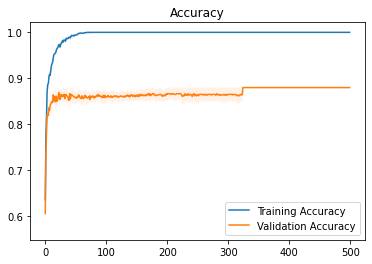


Hyperparameters:
{'batch_size': 128, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.5, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [0], 'D_out': 10}
Accuracy: 0.8620117123111136


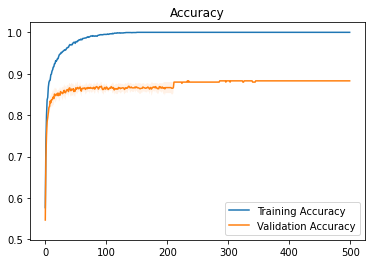


Hyperparameters:
{'batch_size': 128, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [0], 'D_out': 10}
Accuracy: 0.8660127193061324


KeyboardInterrupt: ignored

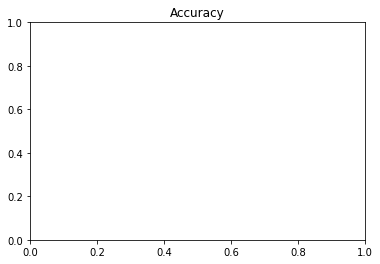

In [ ]:
# No hidden layers
hyperparameters['D_h'] = ([0],)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=3, verbose=True, plot_acc='mean')

In [ ]:
# One hidden layer with ReLU activations
hyperparameters['D_h'] = ([128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=20, verbose=True, plot_acc=False)

In [ ]:
# Two hidden layers with ReLU activations
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=20, verbose=True, plot_acc=False)

# Experiment 2: Activations

Tuning MLP on training set:
0
1


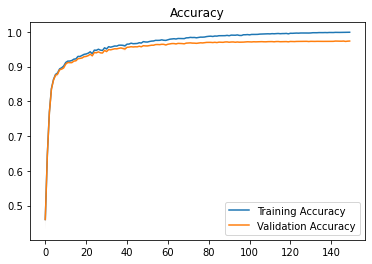


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 150, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'sigmoid', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9732486624331217

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 150, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'sigmoid', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.9732486624331217


In [ ]:
# Sigmoid activations
hyperparameters = {
    'batch_size': (264,1280),
    'early_stopping': (True,),
    'max_epochs': (1500,),
    'learning_rate': (0.25, 1e-1, 1e-2),
    'L2_regularization_param': (0,),
    'epsilon': (1e-8,), # If needed (I commented out this part in the code for now)
    'dropout': (0.0,), # If we decide to implement
    'activation': ('sigmoid',),
    'D_in': (X_train.shape[1],),
    'D_h': ([128, 128],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'clip_grad_norm': (False,) # False or threshold for clipping norm
}

best_hyperparameters = {
    'batch_size': (264,),
    'early_stopping': (True,),
    'max_epochs': (150,),
    'learning_rate': (0.25,),
    'L2_regularization_param': (0,),
    'epsilon': (1e-8,), # If needed (I commented out this part in the code for now)
    'dropout': (0.0,), # If we decide to implement
    'activation': ('sigmoid',),
    'D_in': (X_train.shape[1],),
    'D_h': ([128, 128],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'clip_grad_norm': (False,) # False or threshold for clipping norm
}
train_test(X_train, y_train, X_test, y_test, best_hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc="mean")

Tuning MLP on training set:
0
1


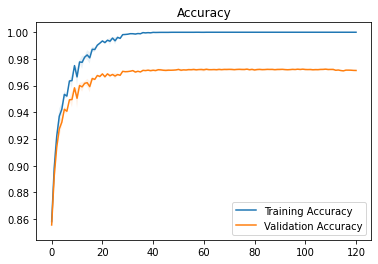


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'tanh', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.972223611180559

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 121, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'tanh', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.972223611180559
Test accuracy using best hyperparameters: 0.9786


In [ ]:
# Tanh activations
best_hyperparameters['D_h'] = ([128,  128],)
best_hyperparameters['max_epochs'] = (500,)
best_hyperparameters['activation'] = ('tanh',)
best_hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, best_hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc="mean")

Tuning MLP on training set:
0
1


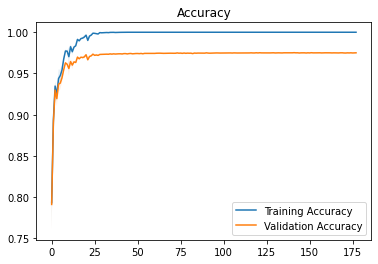


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9750487524376219

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 178, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.9750487524376219
Test accuracy using best hyperparameters: 0.9782


In [ ]:
# ReLU activations
best_hyperparameters['D_h'] = ([128, 128],)
best_hyperparameters['activation'] = ('ReLU',)
best_hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, best_hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc="mean")

Tuning MLP on training set:
0
1


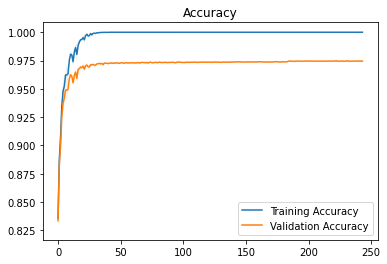


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'leaky_ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9739236961848092

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 244, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'leaky_ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.9739236961848092
Test accuracy using best hyperparameters: 0.9789


In [ ]:
# leaky ReLU activations
best_hyperparameters['D_h'] = ([128, 128],)
best_hyperparameters['activation'] = ('leaky_ReLU',)
best_hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, best_hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc="mean")

# Experiment 3: L2 regularization

In [ ]:
# Two hidden layers with ReLU activations and L2 regularization
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['learning_rate']: (0.25,)
hyperparameters['L2_regularization_param'] = (1, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=7, verbose=True, plot_acc=False)

In [ ]:
# Two hidden layers with ReLU activations and L2 regularization also optimizing for learning rate
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['learning_rate'] = (0.5, 0.25, 1e-1, 1e-2, 1e-3, 1e-4)
hyperparameters['L2_regularization_param'] = (1, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=7, verbose=True, plot_acc=False)

Tuning MLP on training set:
0
1
2


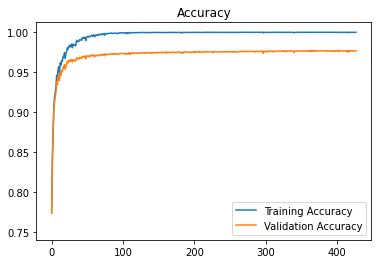


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.1, 'L2_regularization_param': 0.1, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9765833348828391

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 428, 'learning_rate': 0.1, 'L2_regularization_param': 0.1, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.9765833348828391


KeyboardInterrupt: ignored

In [ ]:
# Accuracy plot for the best model
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['learning_rate'] = (1e-1,)
hyperparameters['L2_regularization_param'] = (1e-1,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='mean')

# Experiment 4: Unnormalized images

In [ ]:
# Unnormalized images without L2
X_train_unnormalized = X_train * 255
X_test_unnormalized = X_test * 255
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train_unnormalized, y_train, X_test_unnormalized, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=6, verbose=True, plot_acc=False)

Tuning MLP on training set:

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.11238333306193023

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.0001, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.8803836168877403

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.5, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128,

In [ ]:
# Unnormalized images with L2
X_train_unnormalized = X_train * 255
X_test_unnormalized = X_test * 255
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (1, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5)
train_test(X_train_unnormalized, y_train, X_test_unnormalized, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=20, verbose=True, plot_acc=False)

Tuning MLP on training set:

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 1, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.11236666556188857

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.1, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.11236666806176358

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.5, 'L2_regularization_param': 0.1, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.099249997996350

Tuning MLP on training set:
0
1
2


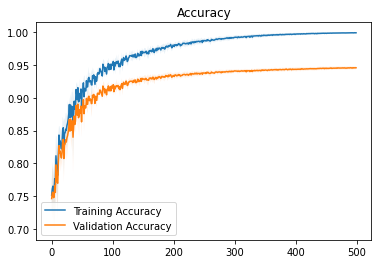


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.001, 'L2_regularization_param': 1.0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9457334647220978

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.001, 'L2_regularization_param': 1.0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.9457334647220978


KeyboardInterrupt: ignored

In [ ]:
# Plot accuracy for best model
X_train_unnormalized = X_train * 255
X_test_unnormalized = X_test * 255
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['learning_rate'] = (0.001,)
hyperparameters['L2_regularization_param'] = (1.,)
train_test(X_train_unnormalized, y_train, X_test_unnormalized, y_test, hyperparameters, RAND, k_folds=3,
           random_search_samples=1, verbose=True, plot_acc='mean')

# Extra experiments

Tuning MLP on training set:


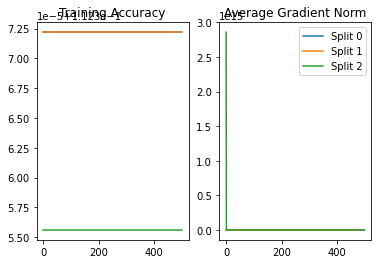


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0.0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.11236666556188857

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0.0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.11236666556188857
Test accuracy using best hyperparameters: 0.1032


In [ ]:
# Extra investigation of the gradient norms to see why the model does not learn with higher learning rates
# Unnormalized images
X_train_unnormalized = X_train * 255
X_test_unnormalized = X_test * 255
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['learning_rate'] = (0.25,)
hyperparameters['L2_regularization_param'] = (0.,)
train_test(X_train_unnormalized, y_train, X_test_unnormalized, y_test, hyperparameters, RAND, k_folds=3,
           random_search_samples=1, verbose=True, plot_acc='norms')

Tuning MLP on training set:


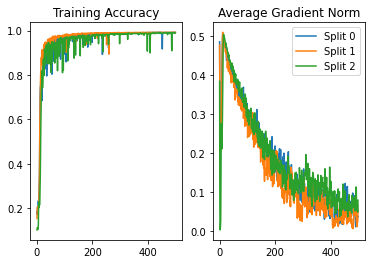


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0.0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': 1.0}
Accuracy: 0.9576833847858444

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0.0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': 1.0}
Best average validation metric: 0.9576833847858444
Test accuracy using best hyperparameters: 0.9641


In [ ]:
# Extra investigation of the gradient norms to see why the model does not learn with higher learning rates
# Unnormalized images, with gradient clipping
X_train_unnormalized = X_train * 255
X_test_unnormalized = X_test * 255
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['learning_rate'] = (0.25,)
hyperparameters['L2_regularization_param'] = (0.,)
hyperparameters['clip_grad_norm'] = (1.0,)
train_test(X_train_unnormalized, y_train, X_test_unnormalized, y_test, hyperparameters, RAND, k_folds=3,
           random_search_samples=1, verbose=True, plot_acc='norms')

Tuning MLP on training set:


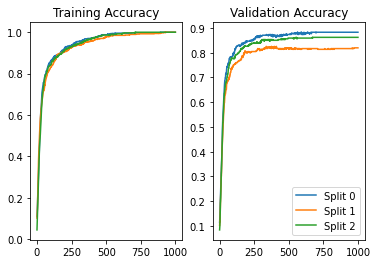


Hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 1000, 'learning_rate': 0.01, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.8549927172681664

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 1000, 'learning_rate': 0.01, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.8549927172681664
Test accuracy using best hyperparameters: 0.8675


In [ ]:
# Showing that early stopping works
# Plot mean training and valid accuracy without early stopping
hyperparameters['early_stopping'] = (False,)
hyperparameters['batch_size'] = (264,)
hyperparameters['max_epochs'] = (1000,)
hyperparameters['learning_rate']: (0.25,)
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='per_split')

Tuning MLP on training set:


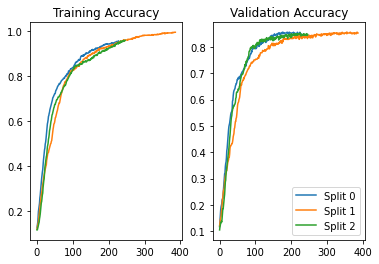


Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 1000, 'learning_rate': 0.01, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128, 128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.8500026973080864

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 387, 'learning_rate': 0.01, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128, 128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.8500026973080864
Test accuracy using best hyperparameters: 0.8501


In [ ]:
# Plot every split's training and valid accuracy with early stopping
hyperparameters['early_stopping'] = (True,)
hyperparameters['batch_size'] = (264,)
hyperparameters['max_epochs'] = (1000,)
hyperparameters['learning_rate']: (0.25,)
hyperparameters['D_h'] = ([128, 128, 128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='per_split')

Tuning MLP on training set:
0
1
2


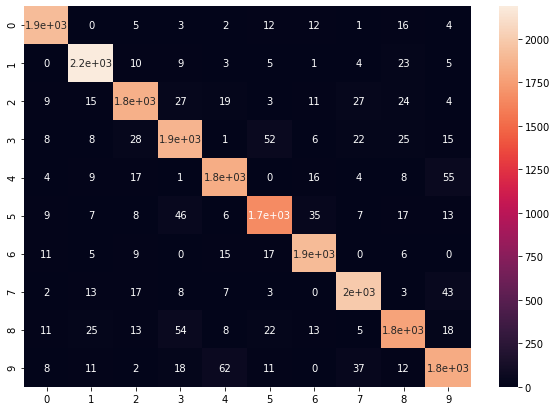

True: 0 | Pred: 3


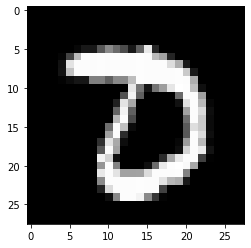

True: 3 | Pred: 2


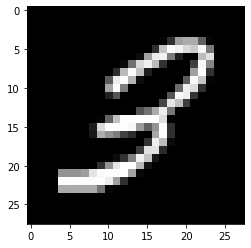

True: 7 | Pred: 2


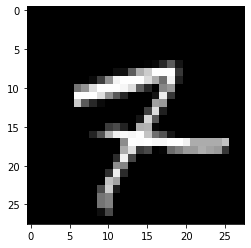

True: 8 | Pred: 5


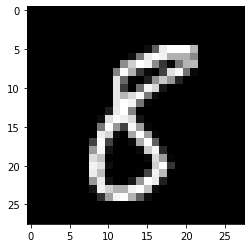

True: 8 | Pred: 6


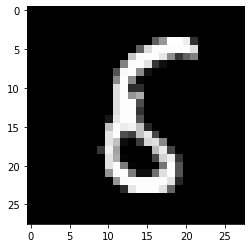


Hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.001, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9401665997041811

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.001, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10, 'clip_grad_norm': False}
Best average validation metric: 0.9401665997041811


KeyboardInterrupt: ignored

In [ ]:
# Investigation of incorrect predictions

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

# Plot mean training and valid accuracy without early stopping
hyperparameters['early_stopping'] = (False,)
hyperparameters['batch_size'] = (264,)
hyperparameters['max_epochs'] = (500,)
hyperparameters['learning_rate']: (0.25,)
hyperparameters['D_h'] = ([128, 128],)
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='confusion_matrix')

In [ ]:
# Analysis of hidden layer width
hyperparameters['early_stopping'] = (True,)
hyperparameters['batch_size'] = (264,)
hyperparameters['max_epochs'] = (500,)
hyperparameters['learning_rate'] = (0.25,)
hyperparameters['D_h'] = ([32], [64], [128], [264], [528])
hyperparameters['activation'] = ('ReLU',)
hyperparameters['L2_regularization_param'] = (0,)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=4, verbose=True, plot_acc=False)

Tuning MLP on training set:
0
1
2

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [264], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9763000648782564
0
1
2

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [528], 'D_out': 10, 'clip_grad_norm': False}
Accuracy: 0.9777334223842146
0
1
2

Hyperparameters:
{'batch_size': 264, 'early_stopping': True, 'max_epochs': 500, 'learning_rate': 0.25, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h':

KeyboardInterrupt: ignored

In [ ]:
# CNN experiment
torch.manual_seed(RAND)
class CNN(nn.Module):
    def __init__(self, config):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input 1x28x28, output 32x28x28
        self.bn1 = nn.BatchNorm2d(32)  # output 32x28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # output 32x14x14
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)  # output 32x14x14
        self.bn2 = nn.BatchNorm2d(32)  # output 64x14x14
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # output 32x7x7
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        if config['activation'] == 'ReLU':
            self.activation = nn.ReLU()
        elif config['activation'] == 'leaky_ReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        self.dropout = nn.Dropout(p=config['dropout'])

    def forward(self, x):
        x = x.reshape(-1, 1, 28, 28)
        h1 = self.pool1(self.activation(self.bn1(self.conv1(x))))
        h1 = self.dropout(h1)
        h2 = self.pool2(self.activation(self.bn2(self.conv2(h1))))
        h2 = self.dropout(h2)
        h3 = self.activation(self.fc1(h2.view(-1, h2.shape[1]*h2.shape[2]*h2.shape[3])))
        h3 = self.dropout(h3)
        out = self.fc2(h3)
        return out


def train_CNN(train_loader, model, config, test_loader=None):

    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    # Setup Early Stopping
    early_stop = EarlyStop(patience=10, reverse=True)
    train_acc = []
    val_acc = []
    running_ap = 0.0
    beta = 0.9

    for epoch in range(config['max_epochs']):

        # --- Train ---
        model.train()
        y_pred_all = []
        y_true_all = []
        for X_batch, y_batch in train_loader:
            y_true_all += y_batch.detach().numpy().tolist()
            y_batch = y_batch.long()
            y_pred = model(X_batch)

            y_pred_prob = softmax(y_pred)
            y_pred_tag = torch.max(y_pred_prob, dim=1).indices

            y_pred_all += y_pred_tag.detach().numpy().tolist()
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc.append(evaluate_acc(np.array(y_true_all), np.array(y_pred_all)))

        # --- Validate ---
        model.eval()
        with torch.no_grad():
            if test_loader is not None:
                y_pred_all = []
                y_true_all = []
                for X_batch, y_batch in test_loader:
                    y_true_all += y_batch.detach().numpy().tolist()
                    y_pred = model(X_batch)
                    
                    y_pred_prob = softmax(y_pred)
                    y_pred_tag = torch.max(y_pred_prob, dim=1).indices

                    y_pred_all += y_pred_tag.detach().numpy().tolist()

                val_acc.append(evaluate_acc(np.array(y_true_all), np.array(y_pred_all)))

                # Update moving average
                if epoch == 0:
                    running_ap = val_acc[-1]
                else:
                    running_ap = beta * running_ap + (1 - beta) * val_acc[-1]

                # early stop
                if config['early_stopping']:
                    if early_stop.update_metric(running_ap, model.state_dict()):
                        # Save best weights
                        model.load_state_dict(early_stop.best_weights)
                        break

    return train_acc, val_acc


# CNN experiment
hyperparameters['model_type'] = ('CNN',)
hyperparameters['early_stopping'] = (True,)
hyperparameters['batch_size'] = (264,)
hyperparameters['max_epochs'] = (500,)
hyperparameters['learning_rate'] = (0.25, 1e-1, 1e-2)
hyperparameters['dropout'] = (0.0,)
hyperparameters['activation'] = ('leaky_ReLU',)
train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=2, random_search_samples=3, verbose=True, plot_acc=False)

Tuning MLP on training set:
0


In [ ]:
# Droupout investigation
hyperparameters = {
    'batch_size': (264,),
    'early_stopping': (True,),
    'max_epochs': (500,),
    'learning_rate': (0.1,),
    'L2_regularization_param': (0,),
    'dropout': (0.0,), # If we decide to implement
    'activation': ('ReLU',),
    'D_in': (X_train.shape[1],),
    'D_h': ([128],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,) # Number of classes
}
dropouts = [0.0,0.1,0.2,0.3,0.4,0.5]
for i in dropouts:
  hyperparameters['dropout'] = (i,)
  train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='mean')
hyperparameters['learning_rate'] = (0.25,)
for i in dropouts:
  hyperparameters['dropout'] = (i,)
  train_test(X_train, y_train, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='mean')

In [ ]:
# Investigating dimensionality reduction with PCA

pca = PCA(n_components = 100)
pca.fit(X_train) #fit PCA with training data instead of the whole dataset
train_data_pca = pca.transform(X_train)
test_data_pca = pca.transform(X_test)
print("PCA completed with 100 components")
print ("training data shape after PCA:",train_data_pca.shape)
print ("testing data shape after PCA:",test_data_pca.shape)

In [ ]:
# Investigating dimensionality reduction with PCA
# Set random seed
RAND = 0
hyperparameters_test_prediction = {
    'batch_size': (64, 128),
    'early_stopping': (True,),
    'max_epochs': (100,),
    'learning_rate': (0.15, 0.2, 0.25, 0.3, 0.35, 0.5),
    'L2_regularization_param': (0.0,),
    'dropout': (0.0,), # If we decide to implement
    'activation': ('leaky_ReLU',),
    'D_in': (train_data_pca.shape[1],),
    'D_h': ([128,128],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,) # Number of classes
}

#best_params ={'batch_size': 64, 'early_stopping': True, 'max_epochs': 50, 'learning_rate': 0.20, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'leaky_ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
#Best average validation metric: 0.9735666198701729

# Load K-fold splits
splits = cross_validation_split(train_data_pca, y_train, stratify=y_train, K=3)

# Tune hyperparameters
samples, keys = random_search(hyperparameters_test_prediction, n_samples=12, RAND=RAND)
best_params, best_metric = tuning_loop(splits, samples, keys, verbose=True, plot_acc='mean')

model = MLP(best_params)

# Train and test
model.fit(train_data_pca, y_train, best_params)
    
y_pred = model.predict(test_data_pca)
test_acc = evaluate_acc(y_test, y_pred)
print('Test accuracy using best hyperparameters: ' + str(test_acc))

In [ ]:
# Investigating dimensionality reduction with PCA
# Set random seed
RAND = 0
hyperparameters_test_prediction = {
    'batch_size': (64, 128),
    'early_stopping': (True,),
    'max_epochs': (100,),
    'learning_rate': (0.15, 0.2, 0.25, 0.3, 0.35, 0.5),
    'L2_regularization_param': (0.0,),
    'dropout': (0.0,), # If we decide to implement
    'activation': ('ReLU',),
    'D_in': (train_data_pca.shape[1],),
    'D_h': ([128,128],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,) # Number of classes
}

#best_params ={'batch_size': 64, 'early_stopping': True, 'max_epochs': 50, 'learning_rate': 0.20, 'L2_regularization_param': 0, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'leaky_ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
#Best average validation metric: 0.9735666198701729

# Load K-fold splits
splits = cross_validation_split(train_data_pca, y_train, stratify=y_train, K=3)

# Tune hyperparameters
samples, keys = random_search(hyperparameters_test_prediction, n_samples=12, RAND=RAND)
best_params, best_metric = tuning_loop(splits, samples, keys, verbose=True, plot_acc='mean')

model = MLP(best_params)

# Train and test
model.fit(train_data_pca, y_train, best_params)
    
y_pred = model.predict(test_data_pca)
test_acc = evaluate_acc(y_test, y_pred)
print('Test accuracy using best hyperparameters: ' + str(test_acc))

# Future investigations (implemented but not tested)

In [ ]:
# Function to initialize weights using different strategies

def weight_initializer(*args, init_type='zero'):
    """
    :param args: Any number of dimension sizes
    :param init_type: Type of weight initialization (we should not use 'zero' with ReLU, I just put it there as a default placeholder
    :return: np.ndarray with weights of shape (*args)
    """
    print(len(args))
    if (init_type=="zero"):
      return np.zeros(args)
    elif (init_type=="random"):
      return np.random.rand(*args)
    elif (init_type=="he"):
      if (len(args)==1):
        return np.random.rand(*args) * np.sqrt(2/args[0])
      elif (len(args)==2):
        return np.random.rand(*args) * np.sqrt(2/args[1])
      else:
        print("Unexpected number of dimensions for weight matrix")
    elif (init_type=="xavier"):
      if (len(args)==1):
        return np.random.rand(*args) * np.sqrt(1/args[0])
      elif (len(args)==2):
        return np.random.rand(*args) * np.sqrt(1/args[1])
      else:
        print("Unexpected number of dimensions for weight matrix")

Tuning MLP on training set:


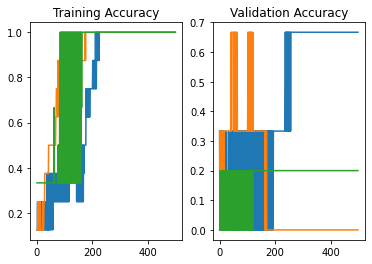


Hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.2888888888888889

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Best average validation metric: 0.2888888888888889
Test accuracy using best hyperparameters: 0.4087
Tuning MLP on training set:


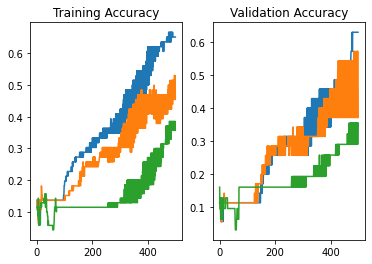


Hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.4516129032258065

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Best average validation metric: 0.4516129032258065
Test accuracy using best hyperparameters: 0.2991
Tuning MLP on training set:


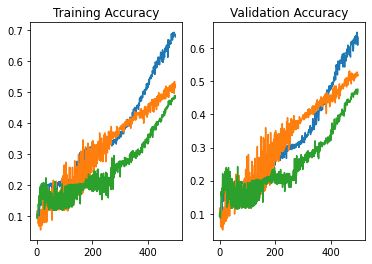


Hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.5430670191149233

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Best average validation metric: 0.5430670191149233
Test accuracy using best hyperparameters: 0.4945
Tuning MLP on training set:


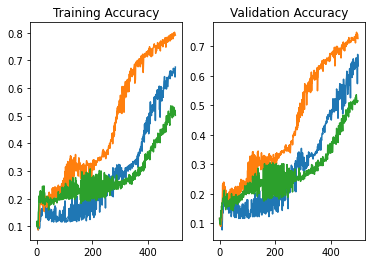


Hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Accuracy: 0.6251101400802

Best hyperparameters:
{'batch_size': 264, 'early_stopping': False, 'max_epochs': 500, 'learning_rate': 0.01, 'L2_regularization_param': 0.01, 'epsilon': 1e-08, 'weight_init': 'He', 'is_bias': True, 'dropout': 0.0, 'batch_norm': False, 'activation': 'ReLU', 'D_in': 784, 'D_h': [128, 128], 'D_out': 10}
Best average validation metric: 0.6251101400802
Test accuracy using best hyperparameters: 0.6136


In [ ]:
#Effect of size of training set on accuracy (Did not finish implementing as we ran out of space in the report)

for i in range(4):
  num_train = 10**(i+1)
  X_train_temp, y_train_temp = X_train[:num_train+1], y_train[:num_train+1]
  train_test(X_train_temp, y_train_temp, X_test, y_test, hyperparameters, RAND, k_folds=3, random_search_samples=1, verbose=True, plot_acc='per_split')

In [ ]:
#Softmax regression investigation (which should be comparable to a 0HL MLP, for use as a baseline)
def softmax(x, axis=None):
    x = x - x.max(axis=1, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=1, keepdims=True)

class LogisticRegression:
    
    def __init__(self, params,n_classes=None):
        self.learning_rate = params["learning_rate"]
        self.max_iters = int(params["max_iters"])   #maximum number of iteration of gradient descent
        self.weights = []
        self.b = []
        self.n_classes = n_classes
        self.regul_type = params["regularization"]
        self.regul_const = params["reg_constant"]

    def fit(self,x,y):
      x = np.insert(x, 0, 1, axis=1)
      classes = np.unique(y)
      self.weights = np.zeros((x.shape[1],len(classes)))
      y_c = np.zeros((len(y), len(classes)))
      for i, j in enumerate(y): #This performs one-hot encoding
        y_c[i, int(j)] = 1
      for epoch in range(self.max_iters):
          soft = softmax(x @ self.weights)
          y_diff = soft - y_c
          grad = (x.T @ y_diff)
          if self.regul_type == "l2":
            self.weights -= (self.learning_rate * (grad+self.regul_const*self.weights)) #apply L2 regularization
          else:
            self.weights -= (self.learning_rate * (grad+self.regul_const*np.sign(self.weights))) #apply L1 regularization
      self.weights = self.weights.T

    def predict(self, x):
      classes = np.arange(self.n_classes)
      x = np.insert(x, 0, 1, axis=1)
      preds = [np.argmax(np.array([(xi @ weight) for weight in self.weights])) for xi in x]
      return [classes[p] for p in preds]

    def evaluate_acc(self, true_y, target_y):
      return np.sum(target_y == true_y)/true_y.shape[0]
      
hyperparameters_lr = {
    'early_stopping': (True),
    'batch_size': (264),
    "max_iters": (500),
    "learning_rate": (0.25),
    "regularization": ("l1"),
    "reg_constant": (0)
}
learning_rate = [0.01,0.1,0.25]
for i in learning_rate:
  hyperparameters['learning_rate'] = (i),;
  model = LogisticRegression(hyperparameters_lr, n_classes = 10)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  test_acc = evaluate_acc(y_test, y_pred)
  print('Test accuracy using best hyperparameters: ' + str(test_acc))

# Save to HTML

In [ ]:
%%shell
#FILE -> download ipynb. from local download folder upload the ipynb file to the colab space. then run line below to get html
jupyter nbconvert --to html MP3_dataloading.ipynb